In [ ]:
import numpy as np 
import pandas as pd    #importing the required models and API's
import os
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [ ]:
def show_image(image,label,get_denormalize=True): #basic function to display the image
    image=image.permute(1,2,0)
    mean=torch.FloatTensor([0.485,0.456,0.406])
    std=torch.FloatTensor([0.229,0.224,0.225]) 
    # Normalize the data set
    
    
    if get_denormalize==True:
        image=image*std+mean # normalizing
        image=np.clip(image,0,1) 
        plt.imshow(image)
        plt.title(label)
        
    else:
        plt.imshow(image)
        plt.title(label)

In [ ]:
def show_grid(image,title=None): #basic function to show the grid
    image=image.permute(1,2,0)
    mean=torch.FloatTensor([0.485,0.456,0.406])
    std=torch.FloatTensor([0.229,0.224,0.225])

    image=image*std+mean
    image=np.clip(image,0,1)
    
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    
    if title!=None:
        plt.title(title)

In [ ]:
def accuracy(y_pred,y_true): #basic function to define the accuracy of the model
    y_pred=F.softmax(y_pred,dim=1) #applying softmax
    top_p,top_class=y_pred.topk(1,dim=1) 
    
    
    equals=top_class==y_true.view(*top_class.shape) 
   
    
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def view_classify(image,ps,label): #function to classify the images into two binary classes of pnuemonic and non-pnuemonic
    class_name=['NORMAL','PNEUMONIA']
    classes=np.array(class_name)
    
    ps=ps.cpu().data.numpy().squeeze()
  
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig,(ax1,ax2)=plt.subplots(figsize=(8,12),ncols=2)
    
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off') 
    ax2.barh(classes,ps) 
    
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes) 
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class-')
    ax2.set_xlim(0,1.1) 
    
    plt.tight_layout()
    
    return None

In [ ]:
class CFG: #class to fetch the dataset from path for colab and also enable the function of the GPU
    epochs=10            
    lr = 0.001           
    batch_size = 16      
    
    
    model_name = 'tf_efficientnet_b4_ns'
    img_size=224 
    
    train_path='../input/chest-xray-pneumonia/chest_xray/train'
    test_path='../input/chest-xray-pneumonia/chest_xray/test'
    validate_path='../input/chest-xray-pneumonia/chest_xray/val'
    
    
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device we are on:{}".format(device))
    

Device we are on:cuda


In [ ]:
from torchvision import transforms as T,datasets #Importing to required API's for preprocessing

In [ ]:
train_transform=T.Compose([
                            T.Resize(size=(CFG.img_size,CFG.img_size)), #preprocessing done by resizing, rotating the image, converting to tensor and normalizing it
    
                            T.RandomRotation(degrees=(-20,+20)), 
                            
    
                            T.ToTensor(), 
                            
    
                            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
    
                            ]) 


validate_transform=T.Compose([
                            T.Resize(size=(CFG.img_size,CFG.img_size)),
                                
                            
    
                            T.ToTensor(),  
                           
    
                            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
    
                            ]) 


test_transform=T.Compose([
                            T.Resize(size=(CFG.img_size,CFG.img_size)),
    
                            
                            T.ToTensor(), 
                            
    
                            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
    
                            ]) 

In [ ]:
from google.colab import drive #import dataset from drive and pass it through the image folder which takes the preprocessing as an argument
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(os.getcwd())


train_data = datasets.ImageFolder('/content/drive/MyDrive/archive/train_data/train',transform=train_transform)
test_data = datasets.ImageFolder('/content/drive/MyDrive/archive/test_data2/test',transform=test_transform)
val_data = datasets.ImageFolder('/content/drive/MyDrive/archive/val_data2/val',transform=test_transform)

Mounted at /content/drive
/content


In [ ]:
print("Trainset Size: {}".format(len(train_data))) #display the sizes of the training ,validation and test data
print("Validateset Size: {}".format(len(val_data)))
print("Testset Size: {}".format(len(test_data)))

Trainset Size: 5216
Validateset Size: 16
Testset Size: 624


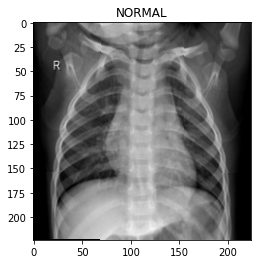

In [ ]:
img,label=train_data[1] #showing a samp;e
class_name=['NORMAL','PNEUMONIA']
show_image(img,class_name[label])

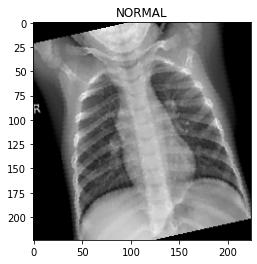

In [ ]:
img,label=train_data[20]
class_name=['NORMAL','PNEUMONIA']
show_image(img,class_name[label])



In [ ]:
from torch.utils.data import DataLoader #batch in train loader for test,train and validation dataset
from torchvision.utils import make_grid
trainloader=DataLoader(train_data,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) # Trainset Size: 5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:326
No. of Total examples:5216


In [ ]:
validationloader=DataLoader(val_data,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(validationloader))) # Validationset Size: 16 / batch_size: 16 = 1(No. of batches in validationl)
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in trainloader:1
No. of Total examples:16


In [ ]:
testloader = DataLoader(test_data,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) # Testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:39
No. of Total examples:624


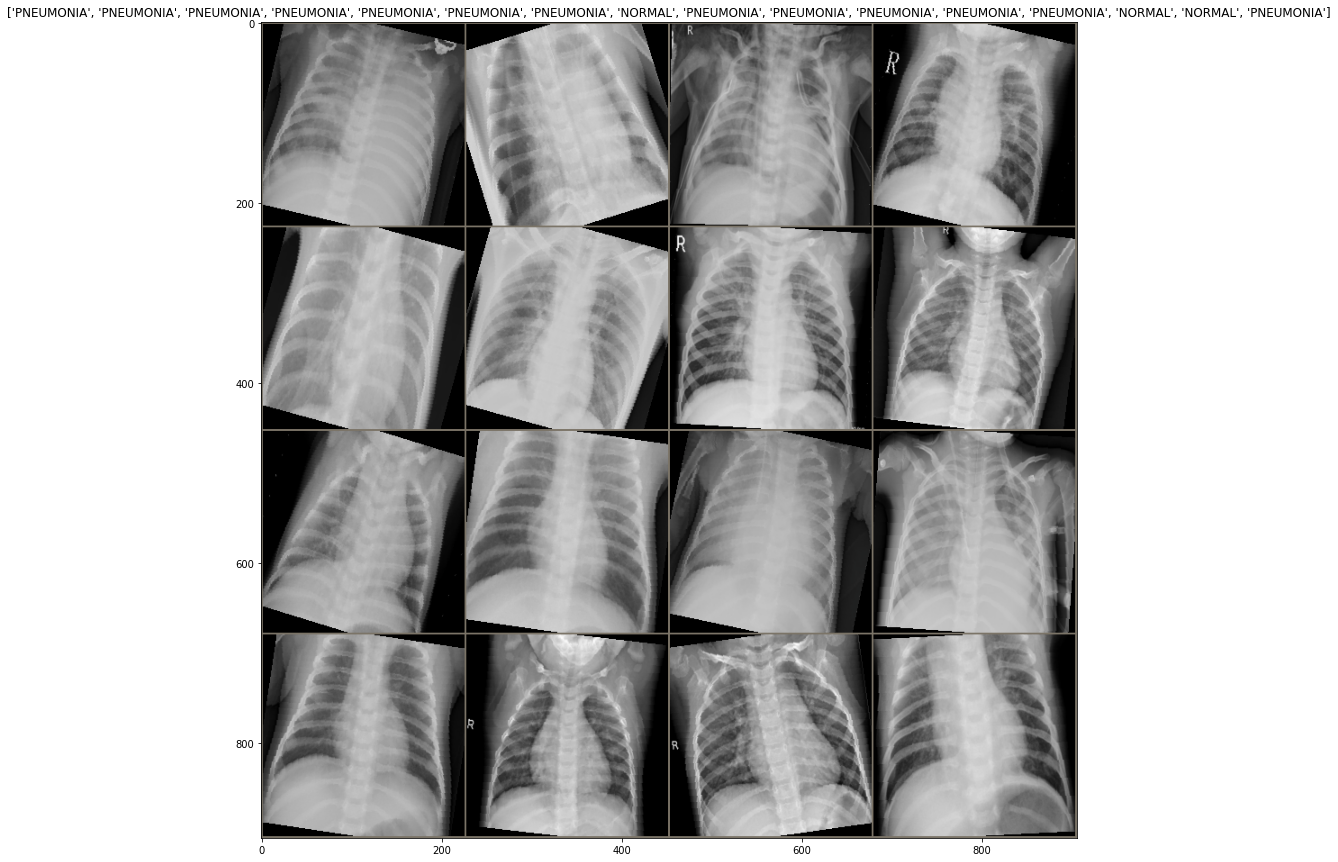

In [ ]:
dataiter=iter(trainloader) #iterate over the trainloader and display randomly in a grid
images,labels=dataiter.next()

out=make_grid(images,nrow=4) 
show_grid(out,title=[class_name[x] for x in labels])

In [ ]:
!pip install timm 

     |████████████████████████████████| 431 kB 4.3 MB/s 


In [ ]:
from torch import nn
import torch.nn.functional as F
import timm 

model=timm.create_model(CFG.model_name,pretrained=True) # Loading the Pretrained model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


In [ ]:
model #display the basic model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [ ]:
for param in model.parameters():
    param.requires_grad=False
    

model.classifier=nn.Sequential(
    nn.Linear(in_features=1792,out_features=625),
    nn.ReLU(), 
    nn.Dropout(p=0.3),

    nn.Linear(in_features=625,out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256,out_features=2),
)


In [ ]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [ ]:
class PneumoniaTrainer(): #class for training 
    
    def __init__(self,criterion=None,optimizer=None,schedular=None):
        self.criterion=criterion #default criterion ,optimizer and sheduler
        self.optimizer=optimizer
        self.schedular=schedular
        
        
    def train_batch_loop(self,model,trainloader):
        
        train_acc=0
        train_loss=0
        
        
        
        for images,labels in tqdm(trainloader):
            
            images=images.to(device)
            labels=labels.to(device)
            logits=model(images)
            loss=self.criterion(logits,labels) 
            
            
            
            self.optimizer.zero_grad() 
            
            loss.backward()
                    
            self.optimizer.step()
         
            
            
            train_loss+=loss.item()
            train_acc+=accuracy(logits,labels)
        
        
        return train_loss/len(trainloader), train_acc/len(trainloader) # return the loss/length ratio
             
    def valid_batch_loop(self,model,validloader):
        valid_loss=0.0
        valid_acc=0.0
        
        for images,labels in tqdm(validloader):
            
           
            images=images.to(device) 
            labels=labels.to(device)
            
            logits=model(images)
            loss=self.criterion(logits,labels)
            
            valid_loss+=loss.item()
            valid_acc+=accuracy(logits,labels)
        return valid_loss/len(validloader),valid_acc/len(validloader)
    
  
    
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss=np.Inf  
        
        for i in range(epochs): #iterate for number of defined epochs
            model.train() 
            avg_train_loss,avg_train_acc=self.train_batch_loop(model,trainloader)
            model.eval() 
            avg_valid_loss,avg_valid_acc=self.valid_batch_loop(model,validloader)
            
            
            if avg_valid_loss<=valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'EffNetPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss
               
                
                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))           

In [ ]:
criterion=nn.CrossEntropyLoss()


optimizer=torch.optim.Adam(model.parameters(),lr=CFG.lr) #optimizer used is ADAM and the loss is Cross Entropy loss

trainer=PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs=CFG.epochs)


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.46238601207733154
Epoch : 1 Train Loss : 0.265508 Train Acc : 0.895130
Epoch : 1 Valid Loss : 0.462386 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.209161 Train Acc : 0.914302
Epoch : 2 Valid Loss : 0.636806 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.190542 Train Acc : 0.925997
Epoch : 3 Valid Loss : 0.479009 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.190376 Train Acc : 0.921396
Epoch : 4 Valid Loss : 0.824156 Valid Acc : 0.562500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.181656 Train Acc : 0.928298
Epoch : 5 Valid Loss : 0.558388 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.168729 Train Acc : 0.933857
Epoch : 6 Valid Loss : 0.526825 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.180464 Train Acc : 0.933474
Epoch : 7 Valid Loss : 0.492828 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.46238601207733154 --> 0.46110233664512634
Epoch : 8 Train Loss : 0.161753 Train Acc : 0.934816
Epoch : 8 Valid Loss : 0.461102 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.153832 Train Acc : 0.937883
Epoch : 9 Valid Loss : 0.678008 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.160143 Train Acc : 0.935583
Epoch : 10 Valid Loss : 0.500042 Valid Acc : 0.750000


In [ ]:
model.load_state_dict(torch.load('./EffNetPneumoniaModel.pt')) 

model.eval()


avg_test_loss,avg_test_acc=trainer.valid_batch_loop(model,testloader) 


print("Test Loss: {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss: 0.287313380302527
Test Acc : 0.8814102411270142
